In [55]:
import numpy as np
import pandas as pd
import re
import random
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict, Counter


In [56]:
def limpar_texto(texto):
    texto = texto.lower()  # Converte tudo para minúsculas
    texto = re.sub(r'[^\w\s]', ' ', texto)  # Remove pontuações
    texto = re.sub(r'\d+', ' ', texto)      # Remove números
    texto = re.sub(r'\s+', ' ', texto)      # Substitui múltiplos espaços por um só
    return texto.strip()

In [57]:
texto_demo = """
A modelagem de linguagem natural é uma técnica importante no processamento de linguagem natural.
Os modelos de linguagem podem ser usados para prever a próxima palavra em uma sequência.
Existem diversos tipos de modelos de linguagem, incluindo modelos baseados em N-grams e modelos neurais.
Os modelos baseados em N-grams são mais simples, mas ainda muito úteis em diversas aplicações.
"""

In [58]:
palavras = limpar_texto(texto_demo).split()
print("Quantidade de palavras:", len(palavras))
print("Exemplo:", palavras[:10])

Quantidade de palavras: 61
Exemplo: ['a', 'modelagem', 'de', 'linguagem', 'natural', 'é', 'uma', 'técnica', 'importante', 'no']


In [59]:
class ModeloNGram:
    def __init__(self, n):
        self.n = n
        self.contagens = defaultdict(Counter)
        self.modelo = {}

    def treinar(self, palavras):
        for i in range(len(palavras) - self.n + 1):
            contexto = tuple(palavras[i:i+self.n-1])
            alvo = palavras[i+self.n-1]
            self.contagens[contexto][alvo] += 1

        for contexto, alvos in self.contagens.items():
            total = sum(alvos.values())
            self.modelo[contexto] = {
                palavra: freq / total for palavra, freq in alvos.items()
            }

    def proxima_palavra(self, contexto):
        contexto = tuple(contexto[-(self.n-1):]) if self.n > 1 else ()
        if contexto in self.modelo:
            palavras = list(self.modelo[contexto].keys())
            probs = list(self.modelo[contexto].values())
            return np.random.choice(palavras, p=probs)
        return None

    def gerar_texto(self, contexto_inicial, quantidade=15):
        if isinstance(contexto_inicial, str):
            contexto_inicial = contexto_inicial.split()
        if len(contexto_inicial) < self.n - 1:
            raise ValueError(f"Contexto inicial deve ter pelo menos {self.n - 1} palavras")
        texto = list(contexto_inicial)
        for _ in range(quantidade):
            prox = self.proxima_palavra(texto)
            if not prox:
                break
            texto.append(prox)
        return ' '.join(texto)

In [60]:
modelo_7gram = ModeloNGram(7)

modelo_7gram.treinar(palavras)


In [61]:
def calcular_perplexidade(modelo, texto_teste):
    tokens = limpar_texto(texto_teste).split()
    log_prob = 0
    total = 0
    for i in range(modelo.n - 1, len(tokens)):
        contexto = tuple(tokens[i - modelo.n + 1:i]) if modelo.n > 1 else ()
        alvo = tokens[i]
        prob = modelo.modelo.get(contexto, {}).get(alvo, 1e-10)
        log_prob += np.log2(prob)
        total += 1
    return 2 ** (-log_prob / total) if total > 0 else float('inf')

texto_teste = " ".join(palavras[:50])

print(texto_teste)
print("Heptagram:", calcular_perplexidade(modelo_7gram, texto_teste))
contexto=['a','modelagem','de','linguagem','natural','tecnica']

a modelagem de linguagem natural é uma técnica importante no processamento de linguagem natural os modelos de linguagem podem ser usados para prever a próxima palavra em uma sequência existem diversos tipos de modelos de linguagem incluindo modelos baseados em n grams e modelos neurais os modelos baseados em n
Heptagram: 1.0


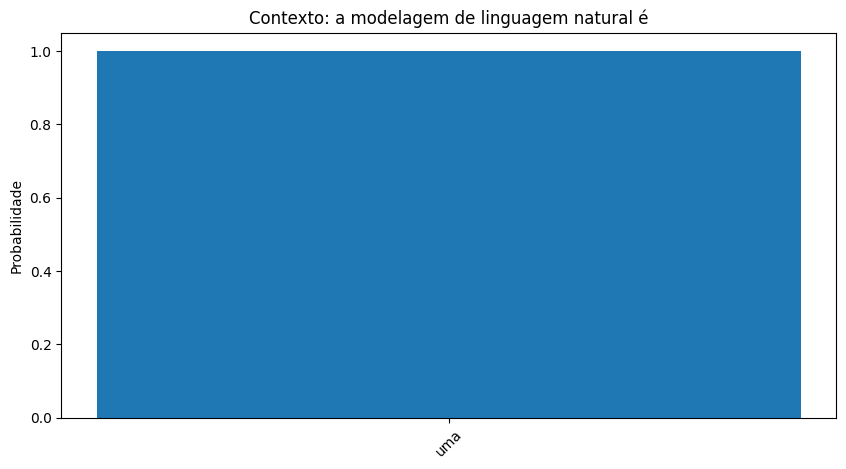

In [62]:
def mostrar_distribuicao(modelo, contexto=None):
    if modelo.n == 1:
        contexto = ()
    if contexto is None or contexto not in modelo.modelo:
        contexto = list(modelo.modelo.keys())[0]
    palavras = list(modelo.modelo[contexto].keys())
    probs = list(modelo.modelo[contexto].values())
    plt.figure(figsize=(10,5))
    plt.bar(palavras[:10], probs[:10])
    titulo = "Distribuição unigram" if modelo.n == 1 else f"Contexto: {' '.join(contexto)}"
    plt.title(titulo)
    plt.ylabel("Probabilidade")
    plt.xticks(rotation=45)
    plt.show()

mostrar_distribuicao(modelo_7gram)

In [63]:
def distancia_edicao(s1, s2):
    if len(s1) < len(s2):
        return distancia_edicao(s2, s1)
    if len(s2) == 0:
        return len(s1)
    anterior = list(range(len(s2) + 1))
    for i, c1 in enumerate(s1):
        atual = [i + 1]
        for j, c2 in enumerate(s2):
            custos = [
                anterior[j + 1] + 1,
                atual[j] + 1,
                anterior[j] + (c1 != c2)
            ]
            atual.append(min(custos))
        anterior = atual
    return anterior[-1]

def sugerir_palavra(palavra, modelo):
    if palavra in modelo.modelo[()]:
        return palavra
    candidatos = []
    for voc in modelo.modelo[()]:
        dist = distancia_edicao(palavra, voc)
        if dist <= 2:
            prob = modelo.modelo[()].get(voc, 0)
            candidatos.append((voc, dist, prob))
    if not candidatos:
        return palavra
    candidatos.sort(key=lambda x: (x[1], -x[2]))
    return candidatos[0][0]

In [65]:
print("")
print("Heptagram:", modelo_7gram.gerar_texto(contexto, 15))


Heptagram: a modelagem de linguagem natural tecnica
